In [1]:
import numpy as np
from scipy import sparse
from scipy.linalg import cholesky, solve_triangular
from scipy.io import loadmat
import time
import matplotlib.pyplot as plt

In [2]:
def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def RL_precision(logbeta, A):
    beta = np.exp(2 * logbeta)    
    A = np.asarray(A, dtype=float)
    n = A.shape[0]
    A = A - np.eye(n)
    iD = np.diag(1 / np.sqrt(A.sum(axis=0))) 
    Lap = np.eye(n) - iD @ A @ iD    
    return np.eye(n) + beta * Lap

In [3]:
def compute_likeli_term(invK, R, tau, HH, Hy):
    invSigma = sparse.kron(sparse.eye(R, format="csr"), invK, format="csr")
    Lambda = (tau * HH + invSigma).toarray()
    cholL = cholesky(Lambda)
    uu = solve_triangular(cholL.T, Hy, lower=True)
    likeli_temp = 0.5 * (tau ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholL)))
    return invSigma, cholL, likeli_temp

def compute_likeli_KU(tau, invKu, HHU, HyU, R):
    invKU, cholLU, likeli_temp = compute_likeli_term(invKu, R, tau, HHU, HyU)
    cholLu = cholesky(invKu)
    likeli_KU = likeli_temp + R * np.sum(np.log(np.diag(cholLu)))
    return cholLu, invKU, cholLU, likeli_KU

def compute_likeli_KV(tau, Kv, HHV, HyV, R):
    eigvalKv, Qvt = np.linalg.eigh(Kv)
    invKv = Qvt @ np.diag(1.0 / eigvalKv) @ Qvt.T
    invKV, cholLV, likeli_temp = compute_likeli_term(invKv, R, tau, HHV, HyV)
    likeli_KV = likeli_temp + 0.5 * R * np.sum(np.log(eigvalKv))
    return eigvalKv, invKV, cholLV, likeli_KV

def prior_theta(hpri, theta):
    mu, lamb = hpri
    return -0.5 * lamb * (theta-mu) ** 2

def theta_range(ranges, theta, min_hp, max_hp):
    tempt = ranges * np.random.rand()
    tmin = max(theta - tempt, min_hp)
    tmax = min(tmin + ranges, max_hp)
    return tmin, tmax

def hyperU_RL_marginal(theta_est, ranges, likeli, tau, HHU, HyU, min_hp, max_hp, hpri, A, R):
    PU = likeli + prior_theta(hpri, theta_est)  
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        invKu_next = RL_precision(theta_next, A)        
        cholLu, invKU_next, cholLU, likeli_next = compute_likeli_KU(tau, invKu_next, HHU, HyU, R)
        PU_next = likeli_next + prior_theta(hpri, theta_next)
        if PU_next - PU > logu:
            return theta_next, invKU_next, cholLU, cholLu, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

def hyperV_Matern_marginal(theta_est, ranges, likeli, tau, HHV, HyV, min_hp, max_hp, hpri, d_Matern, matern_var, T, R):    
    PV = likeli + prior_theta(hpri, theta_est)
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        Kv_next = cov_matern(d_Matern, [theta_next, np.log(matern_var)], np.arange(1, T + 1))
        eigvalKv, invKV_next, cholLV, likeli_next = compute_likeli_KV(tau, Kv_next, HHV, HyV, R)
        PV_next = likeli_next + prior_theta(hpri, theta_next)
        if PV_next - PV > logu:
            return theta_next, invKV_next, cholLV, eigvalKv, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

In [4]:
def mvnrnd_pre_ch(mean, chol_prec):
    z = np.random.randn(mean.shape[0], 1)
    return mean + solve_triangular(chol_prec, z, lower=False)

def sample_factor(tau, cholL, Hy, N):
    tmp = solve_triangular(cholL.T, Hy, lower=True)
    Mean = tau * solve_triangular(cholL, tmp, lower=False)
    temp_vec = mvnrnd_pre_ch(Mean, cholL)
    return temp_vec.reshape((N[0], N[1]), order="F")

In [5]:
def sample_tau(Y, Y_est, mask_matrix, num_obser, a0, b0):
    Err = np.linalg.norm((Y - Y_est) * mask_matrix, ord='fro')**2
    a_tau = a0 + 0.5 * num_obser
    b_tau = b0 + 0.5 * Err
    return np.random.gamma(shape=a_tau, scale=1.0 / b_tau)

In [6]:
def compute_factor_term(G, mask, Y, dim):
    Psi = sparse.kron(G, sparse.eye(dim, format="csr"), format="csr")
    mask_vec = (np.asarray(mask).ravel(order="F") == 1)
    rows = np.flatnonzero(mask_vec)
    Psi_mask = Psi[rows, :]
    HH = Psi_mask.T @ Psi_mask
    y_obs = np.asarray(Y).ravel(order="F")[mask_vec].reshape(-1, 1)
    Hy = Psi_mask.T @ y_obs
    return HH, Hy

In [7]:
def compute_mae(Y, Y_est, mask_test):
    return np.sum(np.abs(Y_est - Y) * mask_test) / np.sum(mask_test)

def compute_rmse(Y, Y_est, mask_test):
    return np.sqrt((np.linalg.norm((Y - Y_est) * mask_test, ord="fro")**2) / np.sum(mask_test == 1))

In [8]:
def BKMF(I, Omega, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, A, d_Matern, a0, b0, R, burn_iter, pos_iter, start):
    N = np.array(I.shape)
    D = I.ndim
    num_obser = np.sum(Omega)
    mask_matrix = [Omega, Omega.T]
    
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    I_train = Isubmean * Omega
    Y_train = [I_train, I_train.T]
    
    G = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    
    max_iter = burn_iter + pos_iter
    mae = np.zeros(max_iter)
    rmse = np.zeros(max_iter)
    G_save = [np.zeros((N[d], R, pos_iter)) for d in range(D)]
    hyper_K = np.zeros((max_iter + 1, D))
    
    hyper_K[0, 0] = np.log(U_gra_scale)
    hyper_K[0, 1] = np.log(V_matern_scale)
    invKu = RL_precision(hyper_K[0, 0], A)
    Kv = cov_matern(d_Matern, [hyper_K[0, 1], np.log(V_matern_var)], np.arange(1, N[1] + 1))
    
    HH = [None] * D
    Hy = [None] * D
    for d in range(D):
        HH[d], Hy[d] = compute_factor_term(G[1-d], mask_matrix[d], Y_train[d], N[d])
    
    tau = np.zeros(max_iter + 1)
    tau[0] = 1e-2
    cholLu, invKU, cholLU, likeli_KU = compute_likeli_KU(tau[0], invKu, HH[0], Hy[0], R)
    eigvalKv, invKV, cholLV, likeli_KV = compute_likeli_KV(tau[0], Kv, HH[1], Hy[1], R)
    
    Y_est_sum = 0
    Y_est_sum2 = 0
    for it in range(burn_iter + pos_iter):
        hyper_K[it+1, 0], invKU, cholLU, cholLu, likeli_KU = hyperU_RL_marginal(
            hyper_K[it, 0], ranges[0], likeli_KU, tau[it], HH[0], Hy[0], min_hp[0], max_hp[0], hpri[0], A, R)

        hyper_K[it+1, 1], invKV, cholLV, eigvalKv, likeli_KV = hyperV_Matern_marginal(
            hyper_K[it, 1], ranges[1], likeli_KV, tau[it], HH[1], Hy[1], min_hp[1], max_hp[1], hpri[1], d_Matern, V_matern_var, N[1], R)
        
        G[0] = sample_factor(tau[it], cholLU, Hy[0], G[0].shape)
        
        HH[1], Hy[1] = compute_factor_term(G[0], mask_matrix[1], Y_train[1], N[1])
        LambdaV = (tau[it] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        G[1] = sample_factor(tau[it], cholLV, Hy[1], G[1].shape)
        
        Y_est = G[0] @ G[1].T
        
        tau[it + 1] = sample_tau(Isubmean, Y_est, mask_matrix[0], num_obser, a0, b0)
        
        if it > burn_iter:
            st_it = it - burn_iter - 1
            for d in range(D):
                G_save[d][:, :, st_it] = G[d]
            Y_est_sum2 = Y_est_sum2 + Y_est
        
        Y_est_sum = Y_est_sum + Y_est
        Y_est_ave = Y_est_sum/(it + 1)
        
        mae[it] = compute_mae(Isubmean, Y_est_ave, mask_test)
        rmse[it] = compute_rmse(Isubmean, Y_est_ave, mask_test)
        
        print(f"Epoch = {it + 1}, tau = {tau[it + 1]}, mae = {mae[it]}, rmse = {rmse[it]}")
        end = time.time()
        print('Running time: %d seconds'%(end - start))
        
        HH[0], Hy[0] = compute_factor_term(G[1], mask_matrix[0], Y_train[0], N[0])
        LambdaU = (tau[it + 1] * HH[0] + invKU).toarray()
        cholLU = cholesky(LambdaU)
        uu = solve_triangular(cholLU.T, Hy[0], lower=True)
        likeli_KU = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLU))) + R * np.sum(np.log(np.diag(cholLu)))
        
        LambdaV = (tau[it + 1] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        uu = solve_triangular(cholLV.T, Hy[1], lower=True)
        likeli_KV = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLV))) + 0.5 * R * np.sum(np.log(eigvalKv))
        
    return G, G_save, hyper_K, tau, mae, rmse, Y_est_sum2

In [9]:
seedr = 6
np.random.seed(seedr)
A = loadmat('../data/traffic/seattle/seattle_adj.mat')['A']
I = loadmat('../data/traffic/seattle/sedata_amonth_matrix.mat')['data_matrix']
N = I.shape
Omega_raw = (I != 0).astype(np.int8)

missing_rate = 0.5 # Random missing (RM)
mask_matrix = (np.round(np.random.rand(N[0], N[1]) + 0.5 - missing_rate)).astype(np.int8)
mask_matrix = mask_matrix & Omega_raw
mask_test = (1 - mask_matrix) & Omega_raw

U_gra_scale = 1
V_matern_scale = 1
V_matern_var = 1
ranges = [np.log(10), np.log(10)]
min_hp = [np.log(1e-3), np.log(1e-6)]
max_hp = [np.log(1e3), np.log(1e6)]
hpri = [None] * 2
hpri[0] = [np.log(10), 1]
hpri[1] = [np.log(10), 1]
d_Matern = 3
a0 = 1e-6
b0 = 1e-6
R = 10
burn_iter = 600
pos_iter = 400

start = time.time()
G, G_save, hyper_K, tau, mae, rmse, Y_est_sum2 = BKMF(
    I, mask_matrix, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, A, d_Matern, a0, b0, R, burn_iter, pos_iter, start)

Epoch = 1, tau = 0.009457794989484973, mae = 6.950149753035083, rmse = 10.52993570430127
Running time: 6 seconds
Epoch = 2, tau = 0.037062554151063326, mae = 4.717965225432562, rmse = 7.176480764611665
Running time: 10 seconds
Epoch = 3, tau = 0.06350336698381266, mae = 3.7403480900966466, rmse = 5.800778227966525
Running time: 15 seconds
Epoch = 4, tau = 0.07882876087531866, mae = 3.215564233378605, rmse = 5.085168867742248
Running time: 20 seconds
Epoch = 5, tau = 0.08430664718121192, mae = 2.9118852940419764, rmse = 4.680640833536759
Running time: 31 seconds
Epoch = 6, tau = 0.08545349423082195, mae = 2.7245792001851963, rmse = 4.4371419014489835
Running time: 34 seconds
Epoch = 7, tau = 0.08595648607395186, mae = 2.6001717982000208, rmse = 4.279483170853914
Running time: 42 seconds
Epoch = 8, tau = 0.08632263263169015, mae = 2.513477094184993, rmse = 4.17212983846582
Running time: 53 seconds
Epoch = 9, tau = 0.08675324842417816, mae = 2.4508524269282335, rmse = 4.096020703739465
Ru

Epoch = 72, tau = 0.08617546987209222, mae = 2.2165546288007403, rmse = 3.82867167162669
Running time: 783 seconds
Epoch = 73, tau = 0.08677656613942165, mae = 2.216554997418077, rmse = 3.8287523430674324
Running time: 796 seconds
Epoch = 74, tau = 0.08675907868261054, mae = 2.2164967588394244, rmse = 3.828866922170601
Running time: 810 seconds
Epoch = 75, tau = 0.08668530814743391, mae = 2.2165584260496685, rmse = 3.8289979940751437
Running time: 820 seconds
Epoch = 76, tau = 0.08619122435956662, mae = 2.2166217608556438, rmse = 3.8290642078702213
Running time: 845 seconds
Epoch = 77, tau = 0.08747134602891858, mae = 2.216580095134563, rmse = 3.8290425634824
Running time: 862 seconds
Epoch = 78, tau = 0.08635099031816161, mae = 2.2165732314721374, rmse = 3.8290323658577985
Running time: 884 seconds
Epoch = 79, tau = 0.08647614717761187, mae = 2.216592237029656, rmse = 3.8290474880174874
Running time: 898 seconds
Epoch = 80, tau = 0.08676036859799034, mae = 2.2164947627340523, rmse = 3

Epoch = 142, tau = 0.08703061788333898, mae = 2.2168610350970748, rmse = 3.8305679484207538
Running time: 1650 seconds
Epoch = 143, tau = 0.08668832602138392, mae = 2.216828885536923, rmse = 3.8305154911703485
Running time: 1659 seconds
Epoch = 144, tau = 0.08608084827251898, mae = 2.2167973736062296, rmse = 3.8305208324956825
Running time: 1679 seconds
Epoch = 145, tau = 0.08651037453355218, mae = 2.21680831869865, rmse = 3.830532586134104
Running time: 1685 seconds
Epoch = 146, tau = 0.0868856736817496, mae = 2.2167912889586385, rmse = 3.8305187647680574
Running time: 1697 seconds
Epoch = 147, tau = 0.08684325607716824, mae = 2.2167554513835244, rmse = 3.830523604688037
Running time: 1708 seconds
Epoch = 148, tau = 0.08669028832617809, mae = 2.216771112176682, rmse = 3.8305818151579976
Running time: 1716 seconds
Epoch = 149, tau = 0.08632206793617353, mae = 2.2167622187634914, rmse = 3.8305883744477693
Running time: 1727 seconds
Epoch = 150, tau = 0.08714832133177203, mae = 2.2167560

Epoch = 212, tau = 0.08677515065295348, mae = 2.217522207118011, rmse = 3.8317784593359328
Running time: 3124 seconds
Epoch = 213, tau = 0.0861172206687962, mae = 2.2175485810790163, rmse = 3.8317970357970816
Running time: 3181 seconds
Epoch = 214, tau = 0.0862374237019716, mae = 2.217544921267442, rmse = 3.831804012426521
Running time: 3215 seconds
Epoch = 215, tau = 0.08654690132885474, mae = 2.21754776138368, rmse = 3.831830241557924
Running time: 3258 seconds
Epoch = 216, tau = 0.08688503909250214, mae = 2.217523218574309, rmse = 3.831819122826002
Running time: 3289 seconds
Epoch = 217, tau = 0.0865960719219058, mae = 2.2175747706322095, rmse = 3.8318766438631453
Running time: 3335 seconds
Epoch = 218, tau = 0.08561968400292903, mae = 2.217592222570024, rmse = 3.831878588495705
Running time: 3369 seconds
Epoch = 219, tau = 0.08652868999370042, mae = 2.217574311162102, rmse = 3.831905800872065
Running time: 3391 seconds
Epoch = 220, tau = 0.08680417073836966, mae = 2.217626265299754

Epoch = 282, tau = 0.08668945239174854, mae = 2.2179332306255817, rmse = 3.832863337708431
Running time: 5738 seconds
Epoch = 283, tau = 0.08682282402121529, mae = 2.217913457744472, rmse = 3.8328561431172283
Running time: 5784 seconds
Epoch = 284, tau = 0.08683089072079202, mae = 2.2179203034641297, rmse = 3.8328759228651577
Running time: 5810 seconds
Epoch = 285, tau = 0.08675616466596976, mae = 2.2179301635958977, rmse = 3.832900817728818
Running time: 5840 seconds
Epoch = 286, tau = 0.08645397003352069, mae = 2.2179350172982026, rmse = 3.8329201776576154
Running time: 5879 seconds
Epoch = 287, tau = 0.08659465480573064, mae = 2.217930700748897, rmse = 3.832917854407674
Running time: 5915 seconds
Epoch = 288, tau = 0.08678707157756925, mae = 2.217957768612302, rmse = 3.8329403908813604
Running time: 5929 seconds
Epoch = 289, tau = 0.0869978067042002, mae = 2.2179842619373056, rmse = 3.832982984233109
Running time: 5958 seconds
Epoch = 290, tau = 0.08692947387834479, mae = 2.21800237

Epoch = 352, tau = 0.08703834454648686, mae = 2.2181660033880117, rmse = 3.8333584664857883
Running time: 8148 seconds
Epoch = 353, tau = 0.08685115655999763, mae = 2.218166610649885, rmse = 3.833372392328994
Running time: 8165 seconds
Epoch = 354, tau = 0.08728356422688857, mae = 2.218206886634693, rmse = 3.833389129678371
Running time: 8215 seconds
Epoch = 355, tau = 0.08612467944826377, mae = 2.2182196801608955, rmse = 3.833400396486828
Running time: 8264 seconds
Epoch = 356, tau = 0.08627143937732851, mae = 2.218231844188332, rmse = 3.833407746272176
Running time: 8301 seconds
Epoch = 357, tau = 0.0870396156900381, mae = 2.2182181507937826, rmse = 3.833399581407257
Running time: 8326 seconds
Epoch = 358, tau = 0.08700216676984698, mae = 2.2182171934754558, rmse = 3.833387235326286
Running time: 8362 seconds
Epoch = 359, tau = 0.0864711491220424, mae = 2.2182065621684663, rmse = 3.833391039604622
Running time: 8383 seconds
Epoch = 360, tau = 0.08665202589504693, mae = 2.218196327080

Epoch = 422, tau = 0.08686662110836876, mae = 2.218621593414505, rmse = 3.833802746394303
Running time: 9964 seconds
Epoch = 423, tau = 0.08742411188140056, mae = 2.2186271035871337, rmse = 3.8338137560424013
Running time: 9984 seconds
Epoch = 424, tau = 0.08629187836745376, mae = 2.218615372343307, rmse = 3.8338013850345787
Running time: 10021 seconds
Epoch = 425, tau = 0.08666128466095435, mae = 2.218640640456192, rmse = 3.833832697450317
Running time: 10041 seconds
Epoch = 426, tau = 0.08703522589421925, mae = 2.21866737580712, rmse = 3.833870392654166
Running time: 10058 seconds
Epoch = 427, tau = 0.08769029760910332, mae = 2.2186757838255735, rmse = 3.8338760139178416
Running time: 10073 seconds
Epoch = 428, tau = 0.08628504650815409, mae = 2.2186918721993405, rmse = 3.8338860281725218
Running time: 10108 seconds
Epoch = 429, tau = 0.0866301383416211, mae = 2.218700713318984, rmse = 3.833878017382011
Running time: 10148 seconds
Epoch = 430, tau = 0.08668684946655635, mae = 2.21870

Epoch = 492, tau = 0.08658611304165605, mae = 2.218775501368112, rmse = 3.834065975606168
Running time: 11736 seconds
Epoch = 493, tau = 0.0869890559561928, mae = 2.2187787692445604, rmse = 3.8340623244529457
Running time: 11760 seconds
Epoch = 494, tau = 0.08642299276107857, mae = 2.218790439084075, rmse = 3.8340658358721775
Running time: 11803 seconds
Epoch = 495, tau = 0.08682601896957291, mae = 2.2187825407092037, rmse = 3.834064640019652
Running time: 11829 seconds
Epoch = 496, tau = 0.08677327924015328, mae = 2.218781444365783, rmse = 3.834065479713626
Running time: 11849 seconds
Epoch = 497, tau = 0.0859911929992552, mae = 2.2187884287759063, rmse = 3.834077560688775
Running time: 11867 seconds
Epoch = 498, tau = 0.08657982762907195, mae = 2.2187960488908445, rmse = 3.8340799018982348
Running time: 11884 seconds
Epoch = 499, tau = 0.08645470382172413, mae = 2.218804286403227, rmse = 3.834089158924516
Running time: 11899 seconds
Epoch = 500, tau = 0.087370591990478, mae = 2.21879

Epoch = 561, tau = 0.08722361530934815, mae = 2.2187404515314078, rmse = 3.834095798678436
Running time: 13542 seconds
Epoch = 562, tau = 0.08685657115470133, mae = 2.2187392456091963, rmse = 3.834106121021432
Running time: 13590 seconds
Epoch = 563, tau = 0.0869531849651622, mae = 2.218738098260992, rmse = 3.834100109978907
Running time: 13605 seconds
Epoch = 564, tau = 0.08608481712439169, mae = 2.2187386318726534, rmse = 3.8340979867127096
Running time: 13643 seconds
Epoch = 565, tau = 0.08668930030673887, mae = 2.2187320608488044, rmse = 3.834102037218532
Running time: 13698 seconds
Epoch = 566, tau = 0.08765549738345461, mae = 2.218736664610394, rmse = 3.8341080201066164
Running time: 13742 seconds
Epoch = 567, tau = 0.08686458895689031, mae = 2.2187407895256017, rmse = 3.834114607974226
Running time: 13760 seconds
Epoch = 568, tau = 0.08662029868734919, mae = 2.218758532090131, rmse = 3.8341112720328963
Running time: 13796 seconds
Epoch = 569, tau = 0.08673217176729199, mae = 2.2

Epoch = 630, tau = 0.08599205484787995, mae = 2.218775364056061, rmse = 3.834270781088303
Running time: 15258 seconds
Epoch = 631, tau = 0.0863450126905858, mae = 2.218765872216126, rmse = 3.834270289235755
Running time: 15280 seconds
Epoch = 632, tau = 0.08672921825478809, mae = 2.218780792710919, rmse = 3.8342865195417275
Running time: 15296 seconds
Epoch = 633, tau = 0.08635173689690571, mae = 2.2187799885498976, rmse = 3.834287012524776
Running time: 15342 seconds
Epoch = 634, tau = 0.08687926293660281, mae = 2.2187777771168946, rmse = 3.8342773104215366
Running time: 15378 seconds
Epoch = 635, tau = 0.08677411125822812, mae = 2.218775513370207, rmse = 3.834270489426554
Running time: 15393 seconds
Epoch = 636, tau = 0.0876842472061703, mae = 2.2187825486389325, rmse = 3.8342833504817735
Running time: 15408 seconds
Epoch = 637, tau = 0.08742579650234703, mae = 2.2187671909259, rmse = 3.8342670661737315
Running time: 15443 seconds
Epoch = 638, tau = 0.08608785865814134, mae = 2.21876

Epoch = 700, tau = 0.08641371435424391, mae = 2.218758029609712, rmse = 3.834243458812794
Running time: 17135 seconds
Epoch = 701, tau = 0.08691813114571822, mae = 2.218762678717226, rmse = 3.8342551211472067
Running time: 17183 seconds
Epoch = 702, tau = 0.08689115870569158, mae = 2.218784089529308, rmse = 3.8342694917966296
Running time: 17211 seconds
Epoch = 703, tau = 0.08675212562902977, mae = 2.2187834171905974, rmse = 3.8342797458372835
Running time: 17247 seconds
Epoch = 704, tau = 0.0871570570902426, mae = 2.218796458460213, rmse = 3.8342913146411486
Running time: 17284 seconds
Epoch = 705, tau = 0.0869062704559232, mae = 2.218803619709806, rmse = 3.834288255754201
Running time: 17310 seconds
Epoch = 706, tau = 0.08694249614368858, mae = 2.2188015232374703, rmse = 3.8342908619804046
Running time: 17342 seconds
Epoch = 707, tau = 0.08601639174267048, mae = 2.2187977186648085, rmse = 3.834289187083989
Running time: 17363 seconds
Epoch = 708, tau = 0.0865609941792475, mae = 2.218

Epoch = 770, tau = 0.08697322175962273, mae = 2.2187034677495494, rmse = 3.834256599063904
Running time: 18855 seconds
Epoch = 771, tau = 0.08740510801273325, mae = 2.2187028219438774, rmse = 3.834257293913317
Running time: 18882 seconds
Epoch = 772, tau = 0.0874521629167115, mae = 2.2187057179494243, rmse = 3.834261200455804
Running time: 18903 seconds
Epoch = 773, tau = 0.08688785187554955, mae = 2.2187069272202065, rmse = 3.8342594714431035
Running time: 18925 seconds
Epoch = 774, tau = 0.08706333642102658, mae = 2.2187204450885827, rmse = 3.8342577024850635
Running time: 18949 seconds
Epoch = 775, tau = 0.08649711500611396, mae = 2.2187268241951568, rmse = 3.834255669402359
Running time: 18978 seconds
Epoch = 776, tau = 0.08677864283002773, mae = 2.218730245452309, rmse = 3.8342495953748594
Running time: 18998 seconds
Epoch = 777, tau = 0.08610419156666645, mae = 2.218736865932434, rmse = 3.834250784653318
Running time: 19032 seconds
Epoch = 778, tau = 0.08665755977429758, mae = 2.

Epoch = 839, tau = 0.08692666717605134, mae = 2.2187676824678055, rmse = 3.8343196057310736
Running time: 20609 seconds
Epoch = 840, tau = 0.08707130956983865, mae = 2.2187747657324737, rmse = 3.8343252352707125
Running time: 20630 seconds
Epoch = 841, tau = 0.08652531730520882, mae = 2.2187806288061585, rmse = 3.8343295303020497
Running time: 20645 seconds
Epoch = 842, tau = 0.0865423901430101, mae = 2.218778593014056, rmse = 3.8343400902687876
Running time: 20654 seconds
Epoch = 843, tau = 0.08687784856855622, mae = 2.2187819588470608, rmse = 3.834334312843183
Running time: 20680 seconds
Epoch = 844, tau = 0.08688098548187609, mae = 2.2187863718714094, rmse = 3.8343468986927935
Running time: 20709 seconds
Epoch = 845, tau = 0.08687973820134445, mae = 2.2187966916898167, rmse = 3.834361041296462
Running time: 20730 seconds
Epoch = 846, tau = 0.0863918832534579, mae = 2.2188128710580823, rmse = 3.8343787349842064
Running time: 20752 seconds
Epoch = 847, tau = 0.08723570426620872, mae =

Epoch = 908, tau = 0.08685953581026534, mae = 2.2187952745999286, rmse = 3.8344238651610465
Running time: 22463 seconds
Epoch = 909, tau = 0.08735665478297208, mae = 2.218789788827335, rmse = 3.8344131948784064
Running time: 22470 seconds
Epoch = 910, tau = 0.08743517279685571, mae = 2.2187871102181367, rmse = 3.8344111295116052
Running time: 22505 seconds
Epoch = 911, tau = 0.08642972608201699, mae = 2.2187918995177083, rmse = 3.8344235480692634
Running time: 22537 seconds
Epoch = 912, tau = 0.08599022537877272, mae = 2.218792895687022, rmse = 3.8344273623909095
Running time: 22549 seconds
Epoch = 913, tau = 0.08686533276951063, mae = 2.2187911654660035, rmse = 3.8344291086964772
Running time: 22586 seconds
Epoch = 914, tau = 0.08702824386727641, mae = 2.2187813813071178, rmse = 3.83442654931803
Running time: 22609 seconds
Epoch = 915, tau = 0.08652746318381367, mae = 2.218793020296452, rmse = 3.8344334843822168
Running time: 22638 seconds
Epoch = 916, tau = 0.08725175101197602, mae =

Epoch = 977, tau = 0.08663087981367917, mae = 2.2188653382332633, rmse = 3.834544386349848
Running time: 24113 seconds
Epoch = 978, tau = 0.08679446882073238, mae = 2.218878341630212, rmse = 3.83455567680102
Running time: 24123 seconds
Epoch = 979, tau = 0.08725590531648643, mae = 2.218882731018387, rmse = 3.834560322332661
Running time: 24141 seconds
Epoch = 980, tau = 0.08616142604855283, mae = 2.2188925025762103, rmse = 3.834571349692695
Running time: 24163 seconds
Epoch = 981, tau = 0.0865135501410981, mae = 2.2188928335275775, rmse = 3.83457940950017
Running time: 24175 seconds
Epoch = 982, tau = 0.08651826942401494, mae = 2.2188907192577005, rmse = 3.834582019385733
Running time: 24201 seconds
Epoch = 983, tau = 0.08699980981222925, mae = 2.2188939261111438, rmse = 3.834593747907363
Running time: 24222 seconds
Epoch = 984, tau = 0.0868344481162115, mae = 2.218896850059286, rmse = 3.8346014714069345
Running time: 24235 seconds
Epoch = 985, tau = 0.08711203094339448, mae = 2.218896

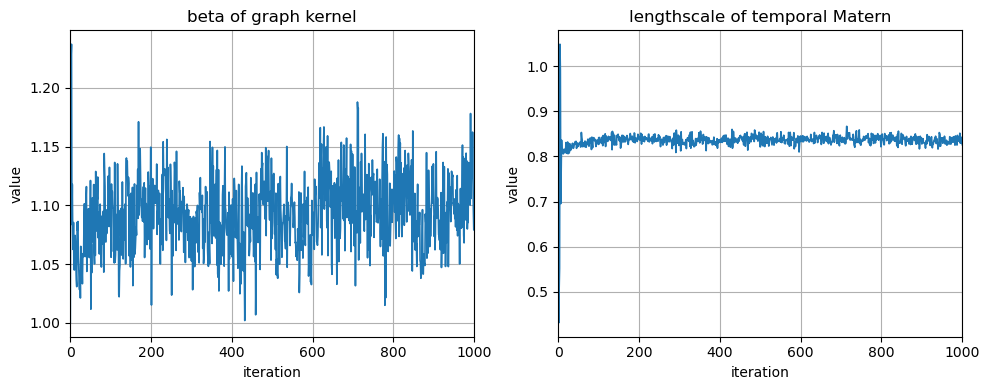

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
fig.set_tight_layout(True)

axes[0].plot(np.exp(hyper_K[:, 0]), linewidth=1.2)
axes[0].set_title("beta of graph kernel")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(0, 1000)

axes[1].plot(np.exp(hyper_K[:, 1]), linewidth=1.2)
axes[1].set_title("lengthscale of temporal Matern")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(0, 1000)

plt.show()

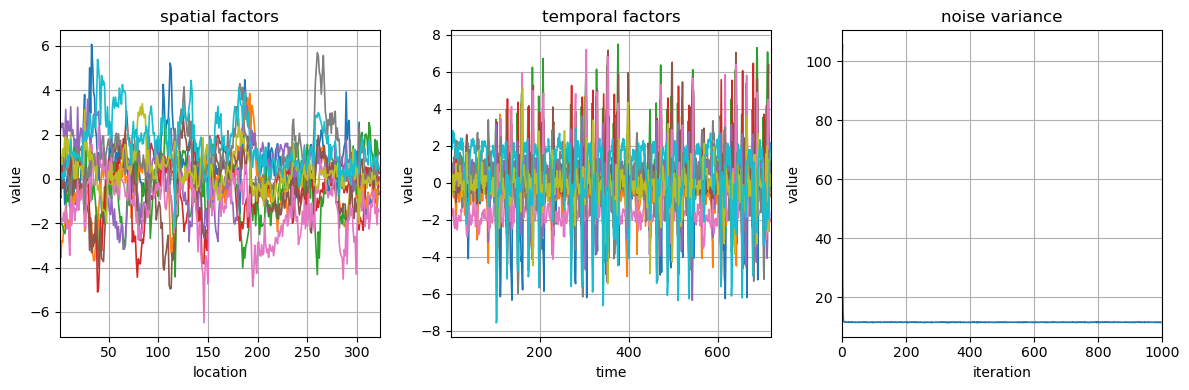

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
fig.set_tight_layout(True)

axes[0].plot(G[0], linewidth=1.2)
axes[0].set_title("spatial factors")
axes[0].grid(True)
axes[0].set_xlabel("location")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, N[0])

axes[1].plot(G[1], linewidth=1.2)
axes[1].set_title("temporal factors")
axes[1].grid(True)
axes[1].set_xlabel("time")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, N[1])

axes[2].plot(1.0 / tau, linewidth=1.2)
axes[2].set_title("noise variance")
axes[2].grid(True)
axes[2].set_xlabel("iteration")
axes[2].set_ylabel("value")
axes[2].set_xlim(0, 1000)

plt.show()

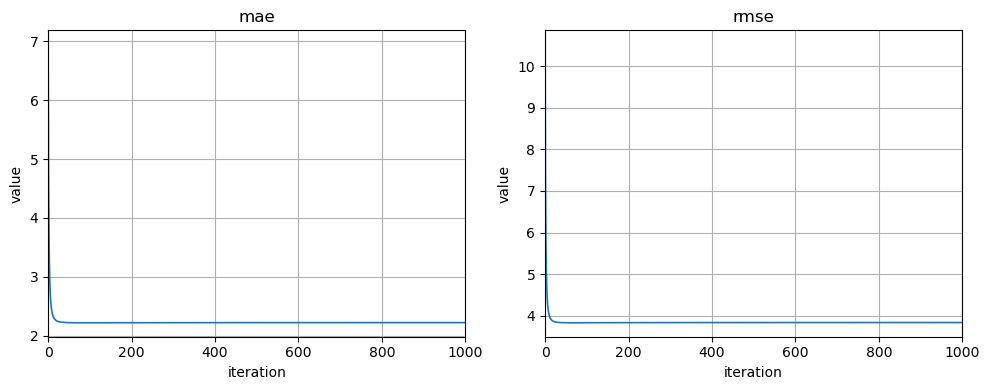

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
fig.set_tight_layout(True)

axes[0].plot(mae, linewidth=1.2)
axes[0].set_title("mae")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(0, 1000)

axes[1].plot(rmse, linewidth=1.2)
axes[1].set_title("rmse")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(0, 1000)

plt.show()